# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own.

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP,
you can read that data using python and preprocess that data this way only:
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients.

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



In [ ]:
!nvidia-smi

Wed Jun 30 03:27:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<font color='blue'>**Download required files**</font>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filepath= '/content/drive/My Drive/Assignments/As31_NLP Attention Mechanism/'

Mounted at /content/drive


In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

> lets download the glove vectors ("vectors for english words"), note that this file will have vectors with 50d, 100d and 300d, you can choose any one of them based on your computing power

__ In our assignment we will be passing english text to the decoder, so we will be using these vectors in decoder embedding layer __

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

In [ ]:
!pip install contractions

In [ ]:
!pip install Unidecode

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,  , Activation
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk.translate.bleu_score as bleu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import datetime

<font color='blue'>**Load the data**</font>

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(350360, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [ ]:
import contractions
import unidecode

def decontractions(text):
    '''
    Ref: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
    '''
    return contractions.fix(text)

def accented_to_ascii(text):
	"""
	Return :- text after converting accented characters
	Input :- string
	Output :- string
  """
	# apply unidecode function on text to convert
	# accented characters to ASCII values
	text = unidecode.unidecode(text)
	return text

def preprocess_eng(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = accented_to_ascii(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data

    text = text.lower()
    text = decontractions(text)
    text = accented_to_ascii(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text

data['english'] = data['english'].apply(preprocess_eng)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


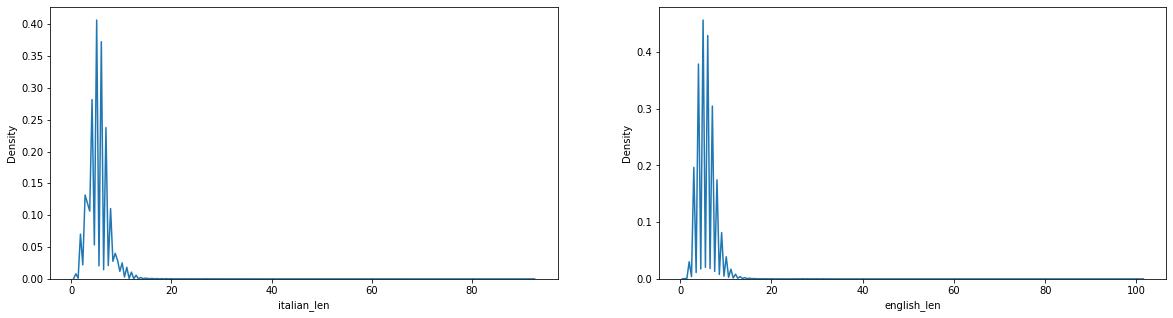

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data['english_len'] = data['english'].str.split().apply(len)

fig, axs = plt.subplots(1,2, figsize= (20,5))
sns.kdeplot(data['italian_len'], ax=axs[0])
sns.kdeplot(data['english_len'], ax=axs[1])
plt.show()

We can see from the above graph that majority of sentences have length less than 20

In [ ]:
print('Italian:')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(data['italian_len'], i))

print('\nEnglish:')
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(data['english_len'], i))

Italian:
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0

English:
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20

In [ ]:
data = data[data['italian_len'] < 20]
data = data[data['english_len'] < 20]

print('Shape of data after filtering for sentences with less than 20 words: ', data.shape)

Shape of data after filtering for sentences with less than 20 words:  (349875, 4)


Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequenc

In [ ]:
data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'
data['english_data'] = '<start> ' + data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)

# 5 random samples
data.sample(5)

,italian,english_inp,english_out,english_data
68097,ne siamo sicure,<start> we are sure of that,we are sure of that <end>,<start> we are sure of that <end>
152992,io sono piu rapido di voi,<start> I am quicker than you are,I am quicker than you are <end>,<start> I am quicker than you are <end>
321535,io non ho mai visto nulla di abbastanza simile...,<start> I have never seen anything quite like ...,I have never seen anything quite like this <end>,<start> I have never seen anything quite like ...
214012,penso di essere innamorato di tom,<start> i think I am in love with tom,i think I am in love with tom <end>,<start> i think I am in love with tom <end>
303429,tom mi disse che aveva saltato la colazione,<start> tom told me he had skipped breakfast,tom told me he had skipped breakfast <end>,<start> tom told me he had skipped breakfast <...


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=42)

print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
# train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
# train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(279900, 4) (69975, 4)


In [ ]:
# Encoder input data: Italian

# Tokenize
tokenizer_ita = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token=1)
tokenizer_ita.fit_on_texts(train['italian'].values)

vocab_size_ita=len(tokenizer_ita.word_index.keys()) +1

# Converting text to sequence tokens
train_ita_encoded = tokenizer_ita.texts_to_sequences(train['italian'])
validation_ita_encoded = tokenizer_ita.texts_to_sequences(validation['italian'])

# pad the sequence
train_ita_padded = pad_sequences(train_ita_encoded, maxlen=20, padding='post')
validation_ita_padded = pad_sequences(validation_ita_encoded, maxlen=20, padding='post')

print('vocab size of italian with zero padding:', vocab_size_ita)
print('Shape of encoder input train data (italian) after padding: ', train_ita_padded.shape)
print('Shape of encoder validation data (italian) after padding: ', validation_ita_padded.shape)

vocab size of italian with zero padding: 26202
Shape of encoder input train data (italian) after padding:  (279900, 20)
Shape of encoder validation data (italian) after padding:  (69975, 20)


In [ ]:
# Decoder input data: English input data

# Tokenize
tokenizer_eng = Tokenizer(filters='', oov_token=1)
tokenizer_eng.fit_on_texts(train['english_data'].values)

vocab_size_eng=len(tokenizer_eng.word_index.keys())+1

# convert text to sequence tokens
train_eng_inp_encoded = tokenizer_eng.texts_to_sequences(train['english_inp'])
validation_eng_inp_encoded = tokenizer_eng.texts_to_sequences(validation['english_inp'])

# pad the sequence
train_eng_inp_padded = pad_sequences(train_eng_inp_encoded, maxlen = 20, padding='post')
validation_eng_inp_padded = pad_sequences(validation_eng_inp_encoded, maxlen = 20, padding='post')

print('vocab size of english with zero padding:', vocab_size_eng)
print('Shape of decoder input train data (english) after padding: ', train_eng_inp_padded.shape)
print('Shape of decoder input validation data (english) after padding: ', validation_eng_inp_padded.shape)

vocab size of english with zero padding: 13128
Shape of decoder input train data (english) after padding:  (279900, 20)
Shape of decoder input validation data (english) after padding:  (69975, 20)


In [ ]:
# Decoder input data: English output data

# convert text to sequence tokens
train_eng_out_encoded = tokenizer_eng.texts_to_sequences(train['english_out'])
validation_eng_out_encoded = tokenizer_eng.texts_to_sequences(validation['english_out'])

# pad the sequence
train_eng_out_padded = pad_sequences(train_eng_out_encoded, maxlen = 20, padding='post')
validation_eng_out_padded = pad_sequences(validation_eng_out_encoded, maxlen = 20, padding='post')

print('vocab size of english with zero padding:', vocab_size_eng)
print('Shape of decoder input train data (english) after padding: ', train_eng_out_padded.shape)
print('Shape of decoder input validation data (english) after padding: ', validation_eng_out_padded.shape)

vocab size of english with zero padding: 13128
Shape of decoder input train data (english) after padding:  (279900, 20)
Shape of decoder input validation data (english) after padding:  (69975, 20)


In [ ]:
# word to index and index to word dictionary

# Italian
ita_index_word={}
ita_word_index={}
for key,value in tokenizer_ita.word_index.items():
  ita_index_word[value]=key
  ita_word_index[key]=value

# English
eng_index_word={}
eng_word_index={}
for key,value in tokenizer_eng.word_index.items():
  eng_index_word[value]=key
  eng_word_index[key]=value

In [ ]:
# Print a sample to verify

idx= np.random.randint(0, 250000)

print('Encoder input Text data:', train['italian'].iloc[idx])
print('Integer representation: ', train_ita_padded[idx])
print('\nDecoder input Text data:', train['english_inp'].iloc[idx])
print('Integer representation: ', train_eng_inp_padded[idx])
print('\nDecoder output Text data:',train['english_out'].iloc[idx])
print('Integer representation: ', train_eng_out_padded[idx])

Encoder input Text data: potrebbe essere difficile da fare
Integer representation:  [230  36 266  28  45   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]

Decoder input Text data: <start> that might be difficult to do
Integer representation:  [  2  16 265  27 400   7  11   0   0   0   0   0   0   0   0   0   0   0
   0   0]

Decoder output Text data: that might be difficult to do <end>
Integer representation:  [ 16 265  27 400   7  11   3   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
# Get embedding matrix

# Ref: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# Ref: https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

glove_input_file = './glove.6B.100d.txt'
glove2word2vec(glove_input_file, word2vec_output_file="gensim_glove_vectors.txt")
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

eng_embedding_matrix = np.zeros((vocab_size_eng, 100))
for word, i in tokenizer_eng.word_index.items():
    try:
      eng_embedding_vector = glove_model.get_vector(word)
      eng_embedding_matrix[i] = eng_embedding_vector
    except:
      continue

print('Shape of embedding matrix:', eng_embedding_matrix.shape)

Shape of embedding matrix: (13128, 100)


In [ ]:
eng_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.25059   ,  0.35765001,  0.23604   , ...,  0.24132   ,
         0.31220001,  1.25230002],
       [ 0.17944001, -0.088062  , -0.16082001, ..., -0.24718   ,
         0.47394001, -0.17682   ]])

In [ ]:
# Creating data pipeline

class Dataset:

    def __init__(self, data, tokenizer_ita, tokenizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tokenizer_ita = tokenizer_ita
        self.tokenizer_eng = tokenizer_eng
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, padding='post', dtype='int32')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, padding='post', dtype='int32')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, padding='post', dtype='int32')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # model.fit_gen requires this function
        return len(self.encoder_inps)

class Dataloader(tf.keras.utils.Sequence):

    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]], batch[2]])

    def __len__(self):   # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_ita, tokenizer_eng, 20)
test_dataset  = Dataset(validation, tokenizer_ita, tokenizer_eng, 20)

BATCH_SIZE = 1024
train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = Dataloader(test_dataset, batch_size=BATCH_SIZE)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size,input_length=input_length,
                                   mask_zero=True, name='Embedding_layer_encoder')
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name='Encoder_LSTM')

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embed = self.embedding(input_sequence)
        # print(input_embed)
        lstm_output, lstm_state_h, lstm_state_c = self.lstm(input_embed, initial_state=initial_states)
        return lstm_output, lstm_state_h, lstm_state_c

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

    def initialize_states(self, batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        lstm_state_h = tf.zeros((batch_size, self.lstm_size))
        lstm_state_c = tf.zeros((batch_size, self.lstm_size))
        return [lstm_state_h, lstm_state_c]

<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)

    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)

    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Decoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length, train_embedding=True):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        if train_embedding:
            self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size,input_length=input_length,
                                       mask_zero=True, name='embedding_layer_decoder')
        else:
            self.embedding = Embedding(input_dim=out_vocab_size, output_dim=eng_embedding_matrix.shape[-1], input_length=input_length,
                                    mask_zero=True, name="embedding_layer_decoder", weights=[eng_embedding_matrix], trainable=False)

        self.lstm = LSTM(lstm_size, return_sequences=True, return_state=True, name='Decoder_LSTM')

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embed = self.embedding(input_sequence)
        decoder_output, decoder_final_state_h, decoder_final_state_c =  self.lstm(target_embed, initial_state = initial_states)
        return decoder_output, decoder_final_state_h, decoder_final_state_c

<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    out_vocab_size=13
    embedding_dim=12
    input_length=10
    dec_units=16
    batch_size=32

    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_= decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True

print(grader_decoder())

True


In [ ]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self, encoder_inputs_length, decoder_inputs_length, output_vocab_size, batch_size=1):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__()
        self.batch_size = batch_size
        self.encoder = Encoder(vocab_size_ita, embedding_size=eng_embedding_matrix.shape[-1], lstm_size=256, input_length=encoder_inputs_length)
        self.decoder = Decoder(vocab_size_eng, embedding_size=eng_embedding_matrix.shape[-1], lstm_size=256, input_length=decoder_inputs_length, train_embedding=False)
        self.dense = Dense(output_vocab_size, activation='softmax')


    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_c
        C. Pass the decoder_outputs into Dense layer

        Return decoder_outputs
        '''
        encoder_inp, decoder_inp = data[0], data[1]
        initial_states = self.encoder.initialize_states(batch_size=self.batch_size)
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(encoder_inp, initial_states)
        decoder_output,_,_ = self.decoder(decoder_inp, [encoder_final_state_h, encoder_final_state_c])
        output = self.dense(decoder_output)

        return output

In [ ]:
# Callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00001, mode='min', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-7, patience=1, mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callback_list = [early_stopping, tensorboard_callback] #, reduce_lr]

In [ ]:
# Create an object of encoder_decoder Model class
# Compile the model and fit the model
tf.keras.backend.clear_session()
model = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20, output_vocab_size=vocab_size_eng, batch_size=BATCH_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model.fit(train_dataloader, batch_size=BATCH_SIZE, epochs=100, steps_per_epoch=train_steps, validation_data=test_dataloader, validation_steps=valid_steps, callbacks=callback_list)
model.summary()

Epoch 1/100
546/546 [==============================] - 80s 137ms/step - loss: 1.6726 - val_loss: 1.4395
Epoch 2/100
546/546 [==============================] - 74s 135ms/step - loss: 1.2947 - val_loss: 1.1504
Epoch 3/100
546/546 [==============================] - 75s 138ms/step - loss: 1.0375 - val_loss: 0.9456
Epoch 4/100
546/546 [==============================] - 75s 138ms/step - loss: 0.8583 - val_loss: 0.7965
Epoch 5/100
546/546 [==============================] - 75s 137ms/step - loss: 0.7143 - val_loss: 0.6755
Epoch 6/100
546/546 [==============================] - 75s 137ms/step - loss: 0.5974 - val_loss: 0.5810
Epoch 7/100
546/546 [==============================] - 75s 137ms/step - loss: 0.5034 - val_loss: 0.5066
Epoch 8/100
546/546 [==============================] - 75s 137ms/step - loss: 0.4285 - val_loss: 0.4495
Epoch 9/100
546/546 [==============================] - 75s 137ms/step - loss: 0.3690 - val_loss: 0.4050
Epoch 10/100
546/546 [==============================] - 75s 137m

In [ ]:
import matplotlib.image as mpimg
# To display tensorboard images

def display_image(file):
  plt.figure(figsize=(15,20))
  img = mpimg.imread(file)
  imgplot = plt.imshow(img)
  plt.show()

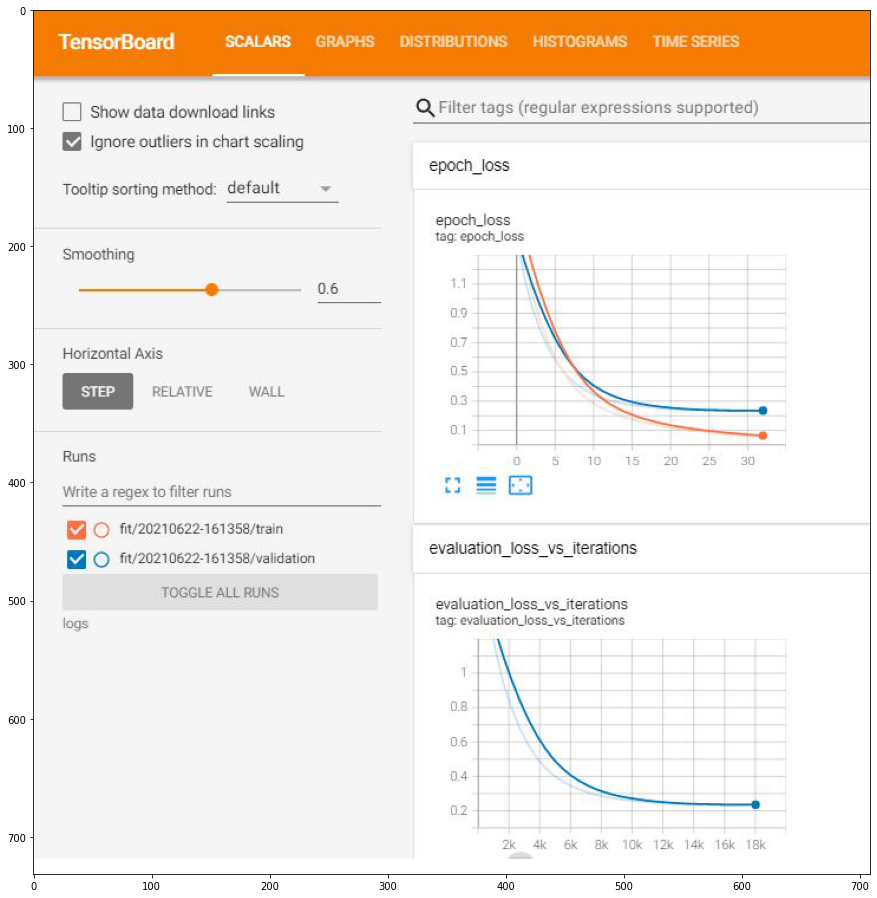

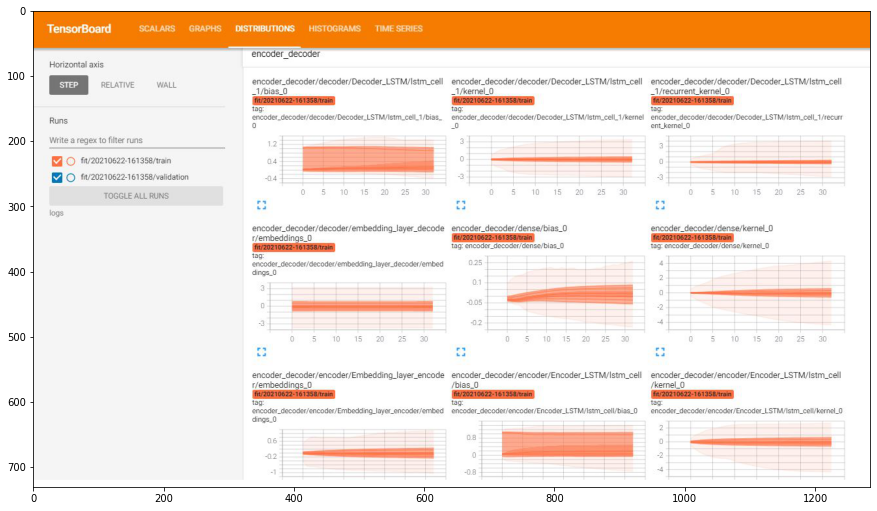

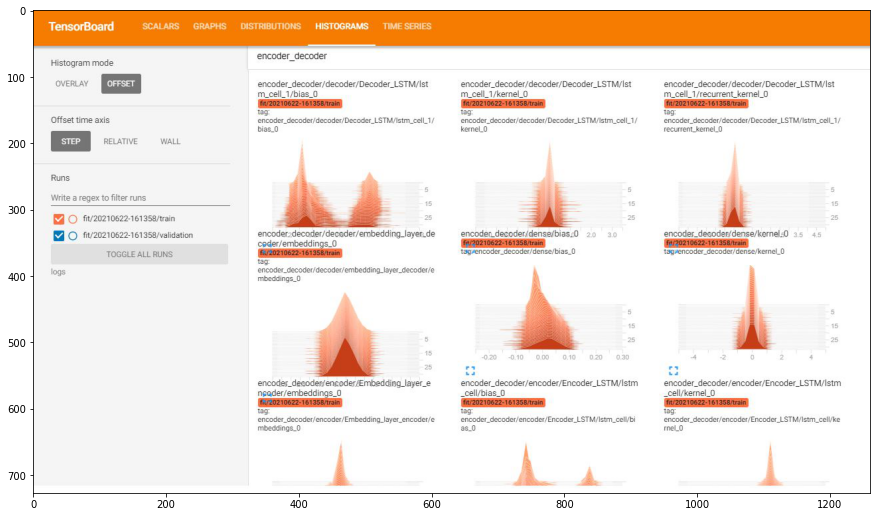

In [ ]:
# Display tensorboard images

display_image(filepath+'1_tensorboard_simple.JPG')
display_image(filepath+'1_distribution_simple.JPG')
display_image(filepath+'1_histogram_simple.JPG')

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

  inp_sequence = np.array(tokenizer_ita.texts_to_sequences([input_sentence]))
  initial_state= model.layers[0].initialize_states(batch_size=1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](inp_sequence, initial_state)
  state_values = [encoder_state_h, encoder_state_c]
  cur_vec = eng_word_index.get('<start>')
  predicted_seq = []

  for i in range(20):
      cur_emb = model.layers[1].embedding(cur_vec)
      dec_output, state_h, state_c = model.layers[1].lstm(np.expand_dims(cur_emb, axis=[0,1]), initial_state=state_values)
      state_values = [state_h, state_c]
      output = model.layers[2](dec_output)
      # np.argmax(output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec = int(np.argmax(output))
      # print("at time step {} the word is {}".format(str(i), eng_index_word.get(cur_vec)))
      predicted_seq.append(cur_vec)
      if cur_vec == eng_word_index.get('<end>'):
          break

  predicted_sentence = [eng_index_word.get(token) for token in predicted_seq]

  return ' '.join(predicted_sentence)

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

from nltk.translate.bleu_score import SmoothingFunction

random_idx = np.sort(np.random.randint(0, validation.shape[0], 1000))
targets = validation.iloc[random_idx]['english_out']
predictions = validation.iloc[random_idx]['italian'].apply(predict)

avg_bleu = 0
for i in range(len(targets)):
    # https://stackoverflow.com/questions/46444656/bleu-scores-could-i-use-nltk-translate-bleu-score-sentence-bleu-for-calculating
    avg_bleu += bleu.sentence_bleu(targets.iloc[i], predictions.iloc[i], smoothing_function=SmoothingFunction().method4) / len(targets)

print('Average Bleu score on 1000 random sentences in test data is ', np.round(avg_bleu,3))

Average Bleu score on 1000 random sentences in test data is  0.337


Kindly note, Bleu score is low because of smoothing function. Without smoothing function bleu score is over 0.8 on 1000 random samples

In [ ]:
for _ in range(10):
    idx = np.random.randint(validation.shape[0])
    print('Input sentence: ', validation['italian'].iloc[idx])
    print('Target sentence: ', validation['english_out'].iloc[idx])
    print('Predicted sentence: ', predict(validation['italian'].iloc[idx]))
    print('-'*80)

Input sentence:  a tom non piacciono i miei amici
Target sentence:  tom does not like my friends <end>
Predicted sentence:  tom does not like my friends <end>
--------------------------------------------------------------------------------
Input sentence:  posso vederla di nuovo
Target sentence:  can i see it again <end>
Predicted sentence:  can i see you again <end>
--------------------------------------------------------------------------------
Input sentence:  tu sei canadese vero
Target sentence:  you are a canadian are not you <end>
Predicted sentence:  you are canadian right <end>
--------------------------------------------------------------------------------
Input sentence:  quanto e laffitto che paghi per lappartamento
Target sentence:  how much rent do you pay for the apartment <end>
Predicted sentence:  how long is the new view to eat up this <end>
--------------------------------------------------------------------------------
Input sentence:  tom ha aiutato sua madre a dec

**We can see that translation for longer sentences is weak that is not so meaningful**

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots,
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only.
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models.
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients.

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(inp_vocab_size, embedding_size, mask_zero=True,
                                   input_length=input_length, name='Embedding_layer_encoder')
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name='Encoder_LSTM')

    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      inp_embed = self.embedding(input_sequence)
      enc_output, enc_state_h, enc_state_c = self.lstm(inp_embed, states)
      return enc_output, enc_state_h, enc_state_c

    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      lstm_state_h = tf.zeros((batch_size, self.lstm_size))
      lstm_state_c = tf.zeros((batch_size, self.lstm_size))
      return [lstm_state_h, lstm_state_c]

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():

    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''

    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)

    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True



<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()
    self.scoring_function = scoring_function

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if self.scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.w = Dense(att_units, use_bias=False)

    elif self.scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.w1 = Dense(att_units, use_bias=False)
      self.w2 = Dense(att_units, use_bias=False)
      self.v = Dense(1, use_bias=False)

  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''

    if self.scoring_function == 'dot':
        # Implement Dot score function here
        attention_weights = Dot(-1)([encoder_output, tf.expand_dims(decoder_hidden_state, axis=1)])
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        context_vector = tf.reduce_sum((attention_weights * encoder_output), axis=1)

    elif self.scoring_function == 'general':
        # Implement General score function here
        attention_weights = Dot(-1)([self.w(encoder_output), tf.expand_dims(decoder_hidden_state, axis=1)])
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        context_vector = tf.reduce_sum((attention_weights * encoder_output), axis=1)

    elif self.scoring_function == 'concat':
        # Implement concat score function here
        attention_weights = self.v(tf.nn.tanh(self.w1(encoder_output) + self.w2(tf.expand_dims(decoder_hidden_state, axis=1))))
        attention_weights = tf.nn.softmax(attention_weights, axis=1)
        context_vector = tf.reduce_sum((attention_weights * encoder_output), axis=1)

    return context_vector, attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):

    '''
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''

    input_length=10
    batch_size=16
    att_units=32

    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights= attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, train_embedding=True):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      if train_embedding:
          self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=embedding_dim,input_length=input_length,
                                       mask_zero=True, name='embedding_layer_decoder')
      else:
          self.embedding = Embedding(input_dim=tar_vocab_size, output_dim=eng_embedding_matrix.shape[-1], input_length=input_length,
                                    mask_zero=True, name="embedding_layer_decoder", weights=[eng_embedding_matrix], trainable=False)
      self.lstm = LSTM(dec_units, return_sequences=True, return_state=True)
      self.attention = Attention(score_fun, att_units)
      self.dense = Dense(tar_vocab_size)

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step-B
    '''
    emb = self.embedding(input_to_decoder)
    context_vector, attention_weights = self.attention(state_h, encoder_output)
    inp_decoder = tf.concat((emb, tf.expand_dims(context_vector,1)), axis=2)
    decoder_output, state_h, state_c = self.lstm(inp_decoder)
    output = tf.squeeze(self.dense(decoder_output))

    return output,state_h,state_c,attention_weights,context_vector

<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):

    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
    '''

    tar_vocab_size=13
    embedding_dim=12
    input_length=10
    dec_units=16
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True

print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units, train_embedding=True):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units, train_embedding=train_embedding)

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        all_outputs = tf.TensorArray(tf.float32, size=20, name='output_array')

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        for timestep in range(20):
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                       encoder_output, decoder_hidden_state, decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)

        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])

        return all_outputs

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):

    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
    '''

    out_vocab_size=13
    embedding_dim=12
    input_length=11
    dec_units=16
    att_units=16
    batch_size=32

    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])

    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units, score_fun ,att_units)
    output=decoder(target_sentences, encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

ValueError: ignored

Checked with the team for the above error and was told to proceed as it is fine

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length, out_vocab_size, embedding_dim, dec_units , score_fun, att_units, train_embedding=True, batch_size=1):
      # Intialize objects from encoder decoder
      super().__init__()
      self.batch_size = batch_size
      self.encoder = Encoder(inp_vocab_size, embedding_size, lstm_size, input_length)
      self.decoder = Decoder(out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units, train_embedding=train_embedding)

  def call(self,data):
      # Intialize encoder states, Pass the encoder_sequence to the embedding layer
      # Decoder initial states are encoder final states, Initialize it accordingly
      # Pass the decoder sequence,encoder_output,decoder states to Decoder
      # return the decoder output

      encoder_inp, decoder_inp = data[0], data[1]
      initial_states = self.encoder.initialize_states(batch_size=self.batch_size)
      encoder_output, encoder_final_state_h, encoder_final_state_c = self.encoder(encoder_inp, initial_states)
      decoder_output = self.decoder(decoder_inp, encoder_output, encoder_final_state_h, encoder_final_state_c)

      return decoder_output

<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

### Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or

# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
def plot_attention(attention, inp_sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  plt.figure(figsize=(10,10))
  g = sns.heatmap(data=attention, cmap='viridis')
  g.set_xticklabels(list(inp_sentence.split()), size=14, rotation=45)
  g.set_yticklabels(predicted_sentence, size=14, rotation=0)
  plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence, plot=False):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  inp_sequence = np.array(tokenizer_ita.texts_to_sequences([input_sentence]))
  initial_state= model.layers[0].initialize_states(batch_size=1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](inp_sequence, initial_state)
  state_h, state_c = encoder_state_h, encoder_state_c
  cur_vec = eng_word_index.get('<start>')
  predicted_seq = []
  attention_weights_lst = []

  for i in range(20):
      decoder_output, state_h,state_c,attention_weights,context_vector = model.layers[1].onestepdecoder(np.expand_dims(cur_vec, axis=[0,1]),
                                                       encoder_output, state_h, state_c)
      attention_weights_lst.append(tf.squeeze(attention_weights))
      cur_vec = int(np.argmax(decoder_output))
      # print("at time step {} the word is {}".format(str(i), eng_index_word.get(cur_vec)))
      predicted_seq.append(cur_vec)
      if cur_vec == eng_word_index.get('<end>'):
          break

  predicted_sentence = [eng_index_word.get(token) for token in predicted_seq]

  if plot:
      plot_attention(attention_weights_lst, input_sentence, predicted_sentence)
      print('\n')

  return ' '.join(predicted_sentence)

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

BLEU score: 0


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

def compute_bleu_score():
    '''
    Computes average Bleu score on 1000 random samples
    '''

    random_idx = np.sort(np.random.randint(0, validation.shape[0], 1000))
    targets = validation.iloc[random_idx]['english_out']
    predictions = validation.iloc[random_idx]['italian'].apply(predict)

    avg_bleu = 0
    for i in range(len(targets)):
        avg_bleu += bleu.sentence_bleu(targets.iloc[i], predictions.iloc[i]) / len(targets)

    print('Average Bleu score on 1000 random sentences in test data is ', np.round(avg_bleu,3))
    print('\n')

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
 #Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function

## Model with dot scoring function

In [ ]:
tf.keras.backend.clear_session()
model = encoder_decoder(vocab_size_ita, embedding_size=100, lstm_size=1024, input_length=20, out_vocab_size=vocab_size_eng,
                            embedding_dim=100, dec_units=1024, score_fun='dot', att_units=1024, train_embedding=False, batch_size=BATCH_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model.fit(train_dataloader, batch_size=BATCH_SIZE, epochs=100, steps_per_epoch=train_steps, validation_data=test_dataloader, validation_steps=valid_steps, callbacks=callback_list)
model.summary()

Epoch 1/100
273/273 [==============================] - 340s 1s/step - loss: 1.7293 - val_loss: 1.4316
Epoch 2/100
273/273 [==============================] - 328s 1s/step - loss: 1.3063 - val_loss: 1.1861
Epoch 3/100
273/273 [==============================] - 329s 1s/step - loss: 1.0803 - val_loss: 0.9812
Epoch 4/100
273/273 [==============================] - 329s 1s/step - loss: 0.8802 - val_loss: 0.8110
Epoch 5/100
273/273 [==============================] - 329s 1s/step - loss: 0.7033 - val_loss: 0.6553
Epoch 6/100
273/273 [==============================] - 330s 1s/step - loss: 0.5559 - val_loss: 0.5401
Epoch 7/100
273/273 [==============================] - 330s 1s/step - loss: 0.4508 - val_loss: 0.4617
Epoch 8/100
273/273 [==============================] - 330s 1s/step - loss: 0.3752 - val_loss: 0.4062
Epoch 9/100
273/273 [==============================] - 330s 1s/step - loss: 0.3198 - val_loss: 0.3709
Epoch 10/100
273/273 [==============================] - 330s 1s/step - loss: 0.279

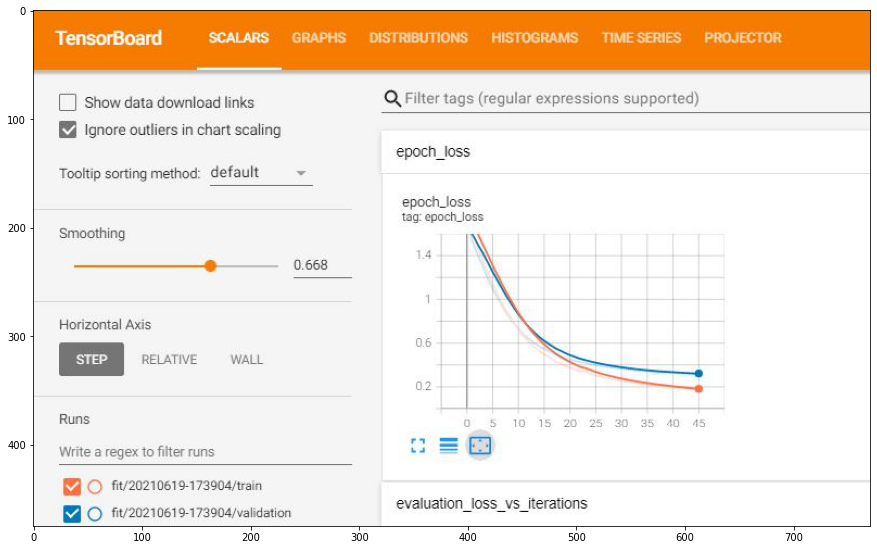

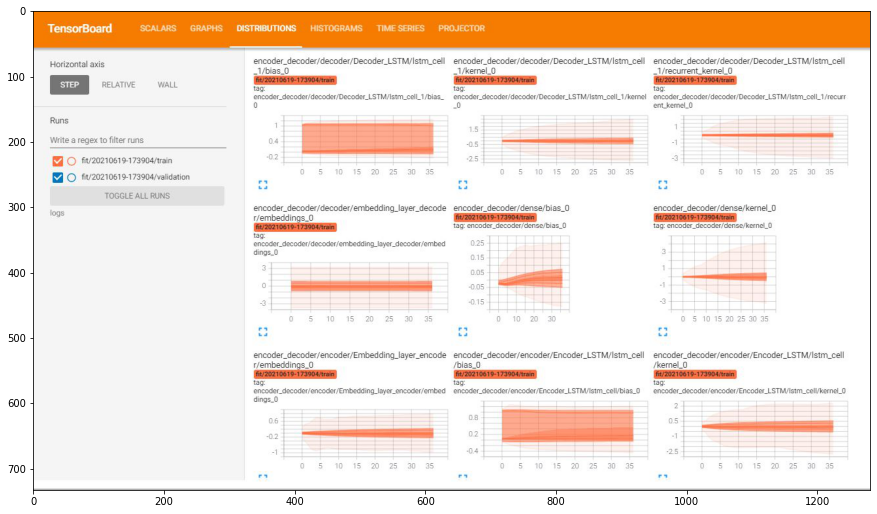

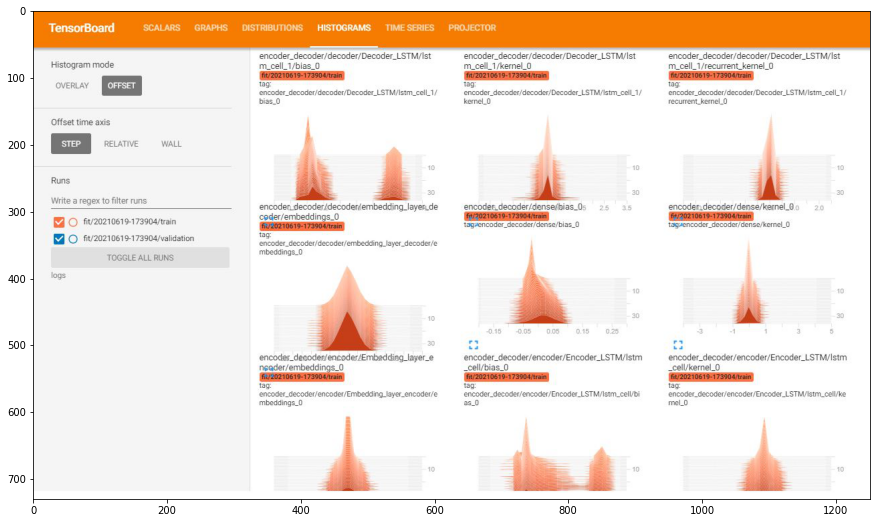

In [ ]:
# Tensorboard images of model using dot scoring function

display_image(filepath+'2_tensorboard_dot.JPG')
display_image(filepath+'2_distribution_dot.JPG')
display_image(filepath+'2_histogram_dot.JPG')

In [ ]:
# Bleu score of model with dot score function on 1000 random sentences in test data

compute_bleu_score()

Average Bleu score on 1000 random sentences in test data is  0.833




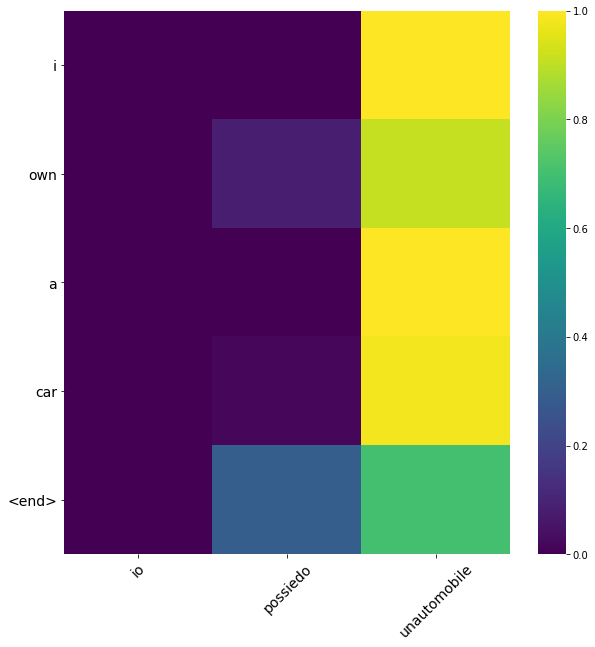

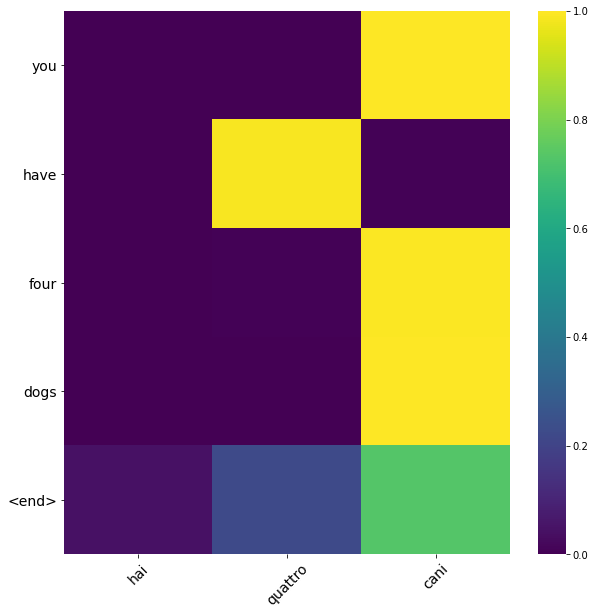

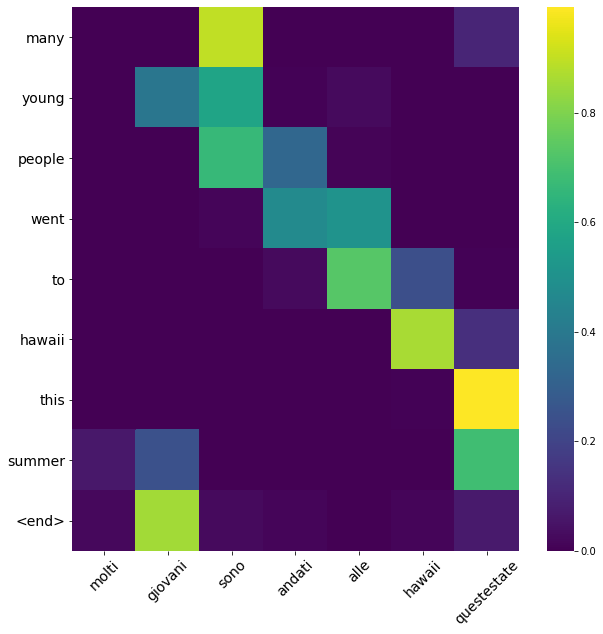

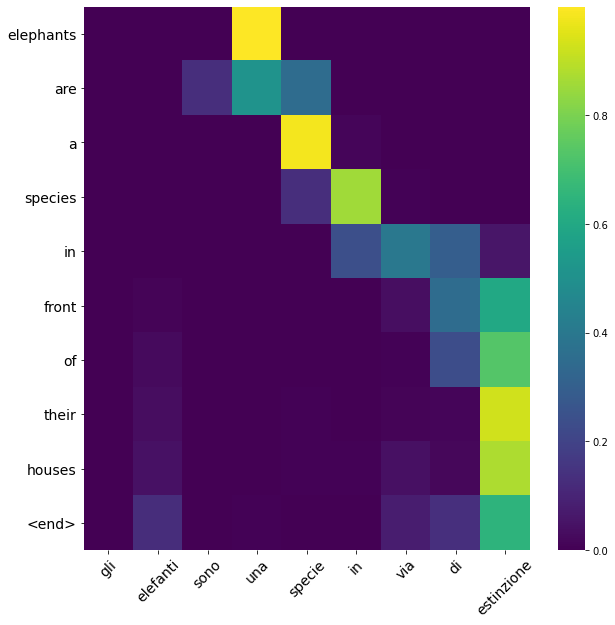

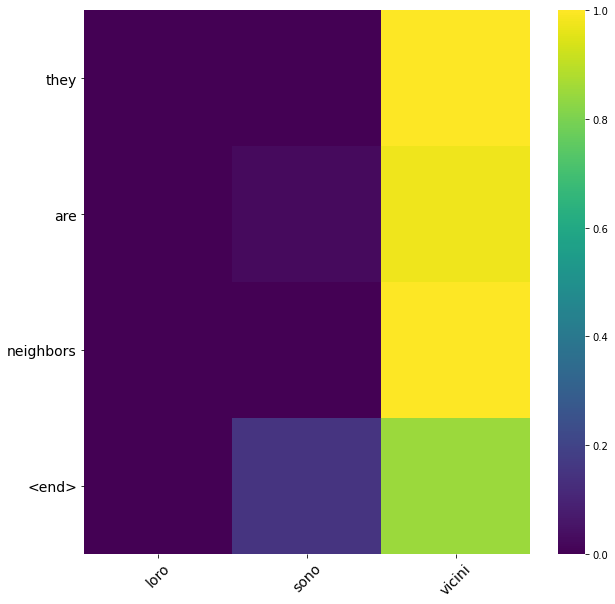

In [ ]:
# Visualize attention weights for random 5 samples
for _ in range(5):
    idx = np.random.randint(0, validation.shape[0])
    _ = predict(validation.iloc[idx]['italian'], plot=True)

In [ ]:
# Prediciton on 10 random samples in test data by model using dot scoring function

for _ in range(10):
    idx = np.random.randint(validation.shape[0])
    print('Input sentence: ', validation['italian'].iloc[idx])
    print('Target sentence: ', validation['english_out'].iloc[idx])
    print('Predicted sentence: ', predict(validation['italian'].iloc[idx]))
    print('-'*80)

Input sentence:  tom cerco di corrompere il poliziotto
Target sentence:  tom tried to bribe the policeman <end>
Predicted sentence:  tom tried to bribe the policeman <end>
--------------------------------------------------------------------------------
Input sentence:  ha bisogno di mangiare la colazione
Target sentence:  you need to eat breakfast <end>
Predicted sentence:  you need to eat breakfast <end>
--------------------------------------------------------------------------------
Input sentence:  lui non vede niente di sbagliato a riguardo
Target sentence:  he sees nothing wrong with it <end>
Predicted sentence:  he sees nothing wrong about that <end>
--------------------------------------------------------------------------------
Input sentence:  e ancora a boston
Target sentence:  are you still in boston <end>
Predicted sentence:  are you still in boston <end>
--------------------------------------------------------------------------------
Input sentence:  qual e la vostra razza

## Model with General scoring function

In [ ]:
tf.keras.backend.clear_session()
BATCH_SIZE = 256
model = encoder_decoder(vocab_size_ita, embedding_size=100, lstm_size=512, input_length=20, out_vocab_size=vocab_size_eng,
                            embedding_dim=100, dec_units=512, score_fun='general', att_units=512, train_embedding=False, batch_size=BATCH_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model.fit(train_dataloader, batch_size=BATCH_SIZE, epochs=100, steps_per_epoch=train_steps, validation_data=test_dataloader, validation_steps=valid_steps, callbacks=callback_list)
model.summary()

Epoch 1/100
1093/1093 [==============================] - 272s 233ms/step - loss: 1.4776 - val_loss: 1.1601
Epoch 2/100
1093/1093 [==============================] - 252s 231ms/step - loss: 1.0109 - val_loss: 0.8978
Epoch 3/100
1093/1093 [==============================] - 252s 231ms/step - loss: 0.8454 - val_loss: 0.7873
Epoch 4/100
1093/1093 [==============================] - 251s 230ms/step - loss: 0.7029 - val_loss: 0.6871
Epoch 5/100
1093/1093 [==============================] - 251s 229ms/step - loss: 0.6273 - val_loss: 0.6075
Epoch 6/100
1093/1093 [==============================] - 251s 230ms/step - loss: 0.5500 - val_loss: 0.5492
Epoch 7/100
1093/1093 [==============================] - 249s 228ms/step - loss: 0.4896 - val_loss: 0.5079
Epoch 8/100
1093/1093 [==============================] - 249s 228ms/step - loss: 0.4265 - val_loss: 0.4568
Epoch 9/100
1093/1093 [==============================] - 249s 228ms/step - loss: 0.3966 - val_loss: 0.4369
Epoch 10/100
1093/1093 [=============

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, mode='min', patience=2, verbose=1, restore_best_weights=True)
callback_list = [early_stopping, tensorboard_callback]

tf.keras.backend.set_value(model.optimizer.learning_rate, 1e-4)
model.fit(train_dataloader, batch_size=BATCH_SIZE, epochs=20, steps_per_epoch=train_steps, validation_data=test_dataloader, validation_steps=valid_steps, callbacks=callback_list)

Epoch 1/20
1093/1093 [==============================] - 249s 228ms/step - loss: 0.0693 - val_loss: 0.2412
Epoch 2/20
1093/1093 [==============================] - 248s 227ms/step - loss: 0.0684 - val_loss: 0.2414
Epoch 3/20
1093/1093 [==============================] - 248s 227ms/step - loss: 0.0671 - val_loss: 0.2412
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


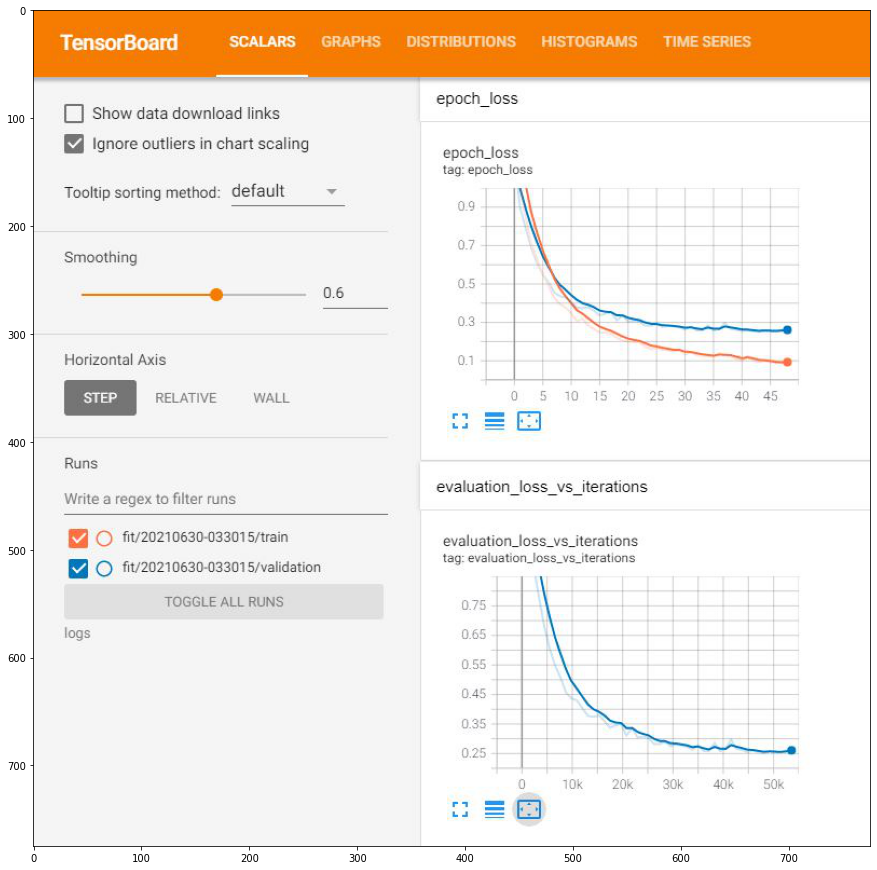

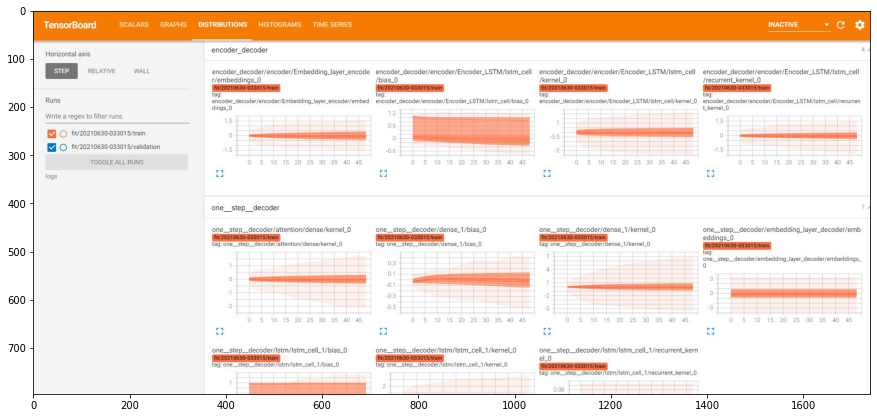

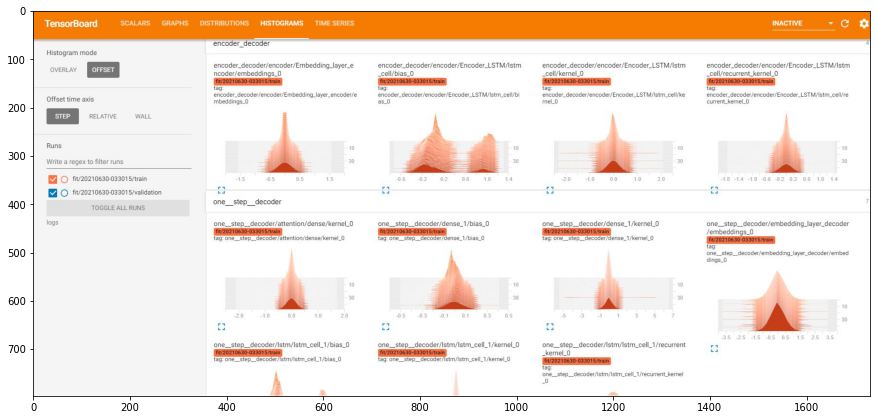

In [ ]:
# Tensorboard images of model using general scoring function

display_image(filepath+'3_tensorboard_general.JPG')
display_image(filepath+'3_distribution_general.JPG')
display_image(filepath+'3_histogram_general.JPG')

In [ ]:
# Bleu score of model with general score function on 1000 random sentences in test data

compute_bleu_score()

Average Bleu score on 1000 random sentences in test data is  0.834




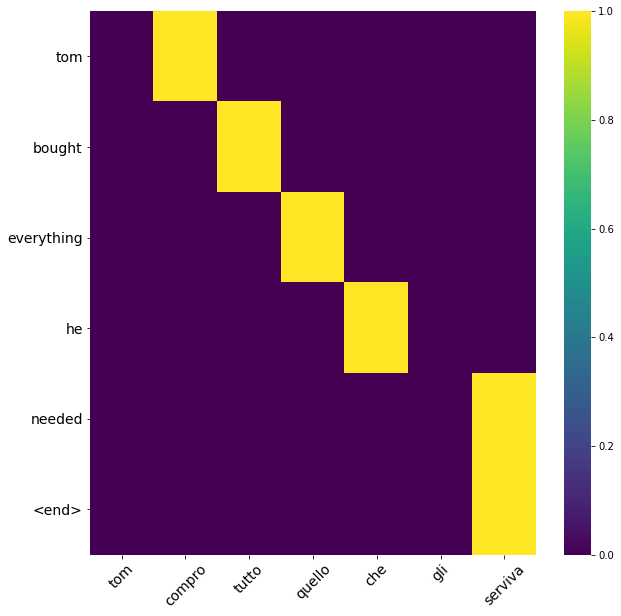

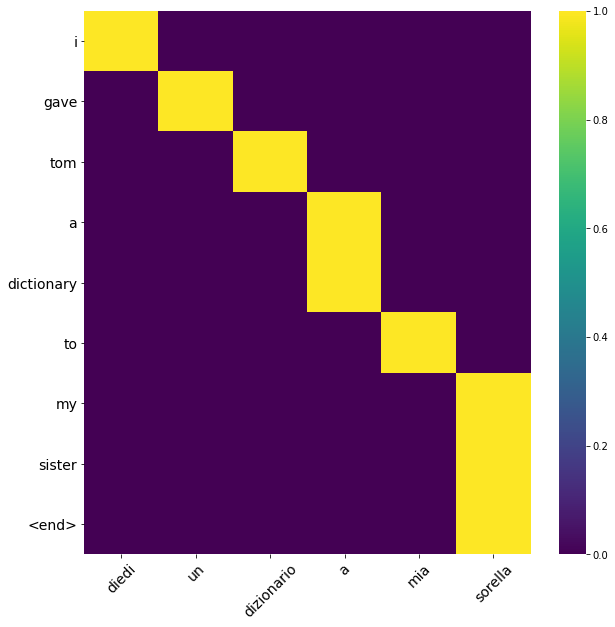

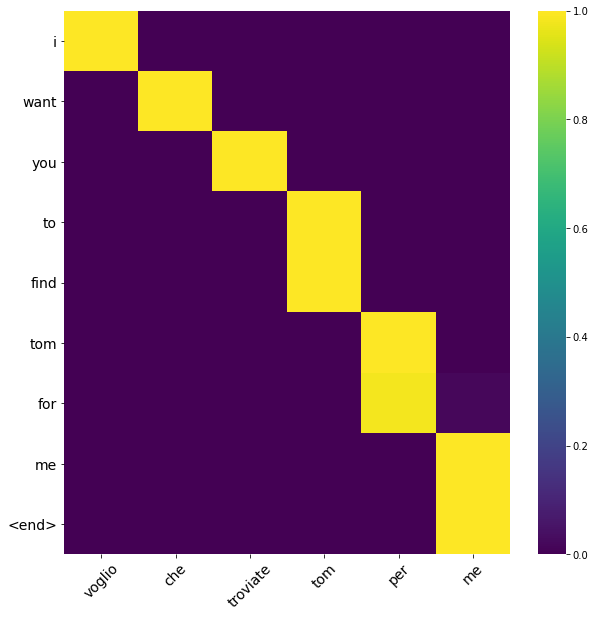

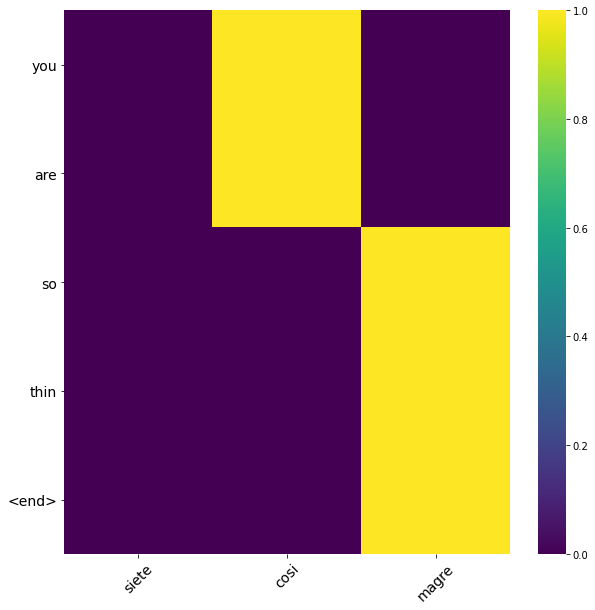

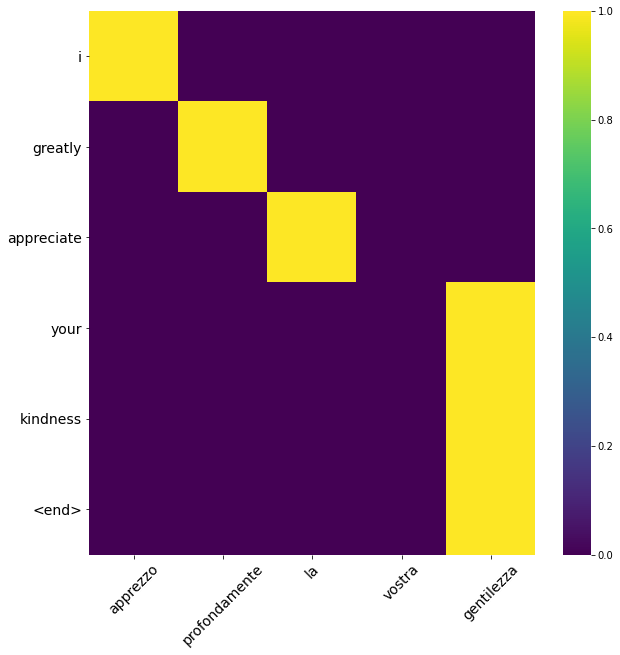

In [ ]:
# Visualize attention weights for random 5 samples
for _ in range(5):
    idx = np.random.randint(0, validation.shape[0])
    _ = predict(validation.iloc[idx]['italian'], plot=True)

In [ ]:
# Prediciton on 10 random samples in test data by model using general scoring function

for _ in range(10):
    idx = np.random.randint(validation.shape[0])
    print('Input sentence: ', validation['italian'].iloc[idx])
    print('Target sentence: ', validation['english_out'].iloc[idx])
    print('Predicted sentence: ', predict(validation['italian'].iloc[idx]))
    print('-'*80)

Input sentence:  noi la dobbiamo riparare
Target sentence:  we have got to fix it <end>
Predicted sentence:  we have got to fix it <end>
--------------------------------------------------------------------------------
Input sentence:  tom non sembrava essere molto felice
Target sentence:  tom did not seem to be very happy <end>
Predicted sentence:  tom did not seem to be very happy <end>
--------------------------------------------------------------------------------
Input sentence:  ha rubato i miei soldi dalla cassaforte
Target sentence:  he stole my money from the safe <end>
Predicted sentence:  he stole my money from the safe <end>
--------------------------------------------------------------------------------
Input sentence:  di chi e lorologio
Target sentence:  whose clock is it <end>
Predicted sentence:  whose turn <end>
--------------------------------------------------------------------------------
Input sentence:  so che lho fatto
Target sentence:  i know i did that <end>
Pr

## Model with Concat scoring function

In [ ]:
tf.keras.backend.clear_session()
model = encoder_decoder(vocab_size_ita, embedding_size=100, lstm_size=512, input_length=20, out_vocab_size=vocab_size_eng,
                            embedding_dim=100, dec_units=512, score_fun='concat', att_units=544, train_embedding=False, batch_size=BATCH_SIZE)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_function)
train_steps=train.shape[0]//BATCH_SIZE
valid_steps=validation.shape[0]//BATCH_SIZE
model.fit(train_dataloader, batch_size=BATCH_SIZE, epochs=100, steps_per_epoch=train_steps, validation_data=test_dataloader, validation_steps=valid_steps, callbacks=callback_list)
model.summary()

Epoch 1/100
273/273 [==============================] - 238s 811ms/step - loss: 1.8117 - val_loss: 1.5109
Epoch 2/100
273/273 [==============================] - 226s 829ms/step - loss: 1.4149 - val_loss: 1.3443
Epoch 3/100
273/273 [==============================] - 226s 830ms/step - loss: 1.2975 - val_loss: 1.2579
Epoch 4/100
273/273 [==============================] - 226s 829ms/step - loss: 1.2201 - val_loss: 1.1880
Epoch 5/100
273/273 [==============================] - 227s 831ms/step - loss: 1.1489 - val_loss: 1.1293
Epoch 6/100
273/273 [==============================] - 227s 831ms/step - loss: 1.0877 - val_loss: 1.0742
Epoch 7/100
273/273 [==============================] - 227s 831ms/step - loss: 1.0313 - val_loss: 1.0216
Epoch 8/100
273/273 [==============================] - 227s 832ms/step - loss: 0.9758 - val_loss: 0.9695
Epoch 9/100
273/273 [==============================] - 227s 832ms/step - loss: 0.9177 - val_loss: 0.9137
Epoch 10/100
273/273 [==============================] -

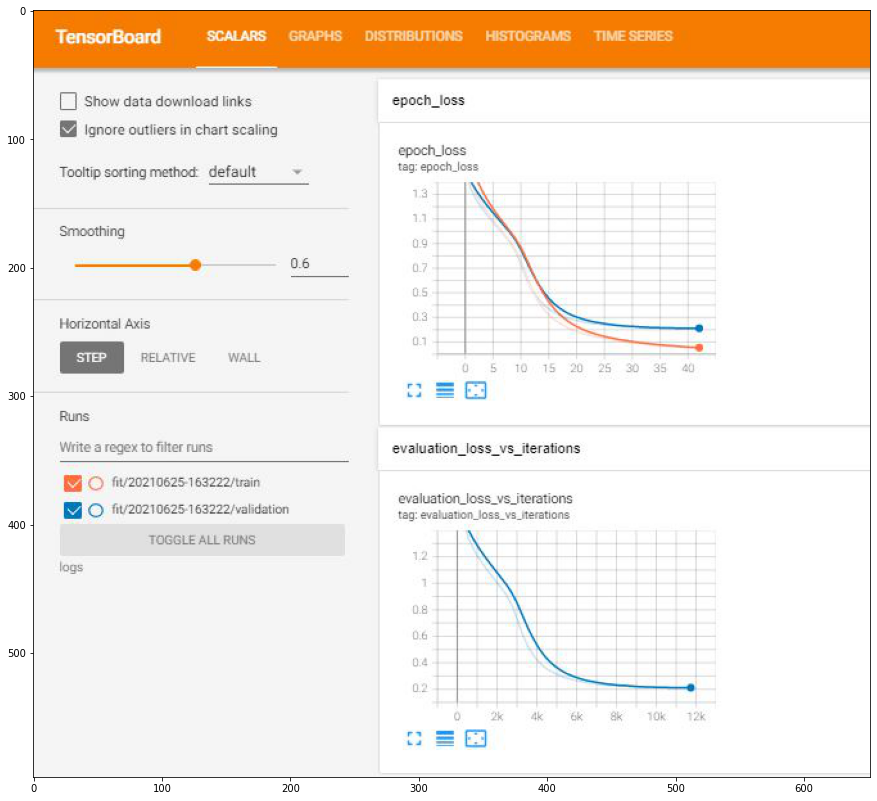

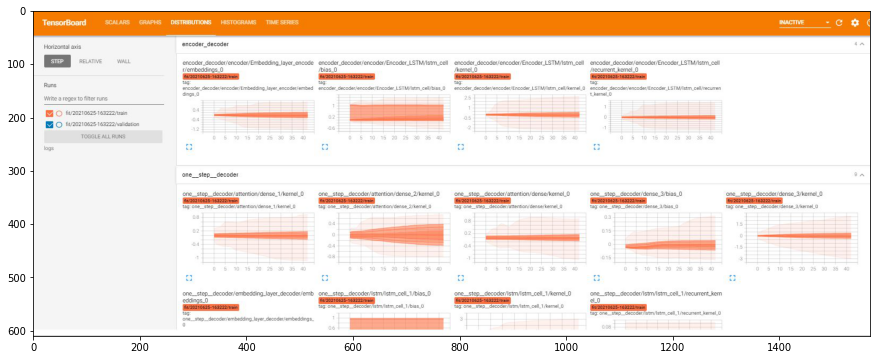

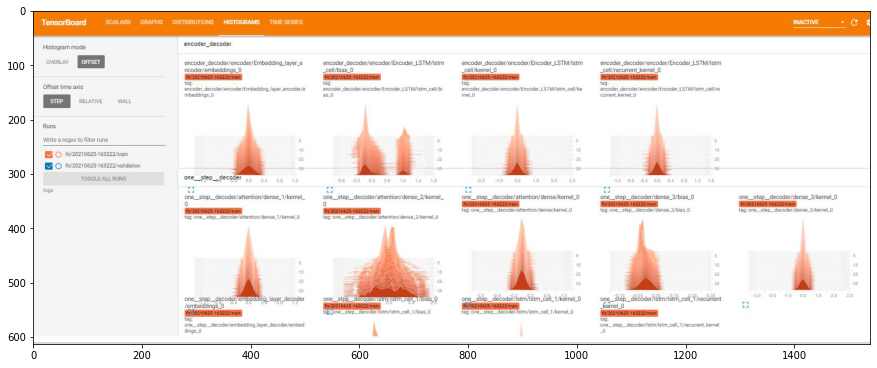

In [ ]:
# Tensorboard images of model using concat scoring function

display_image(filepath+'4_tensorboard_concat.JPG')
display_image(filepath+'4_distribution_concat.JPG')
display_image(filepath+'4_histogram_concat.JPG')

In [ ]:
# Bleu score of model with concat score function on 1000 random sentences in test data

compute_bleu_score()

Average Bleu score on 1000 random sentences in test data is  0.849




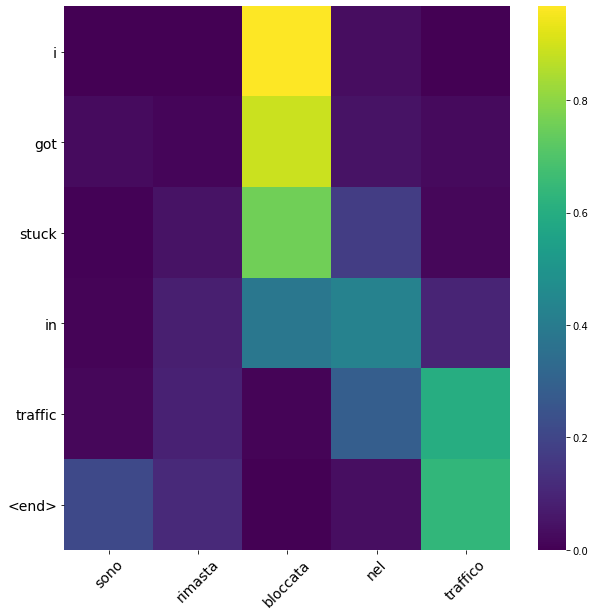

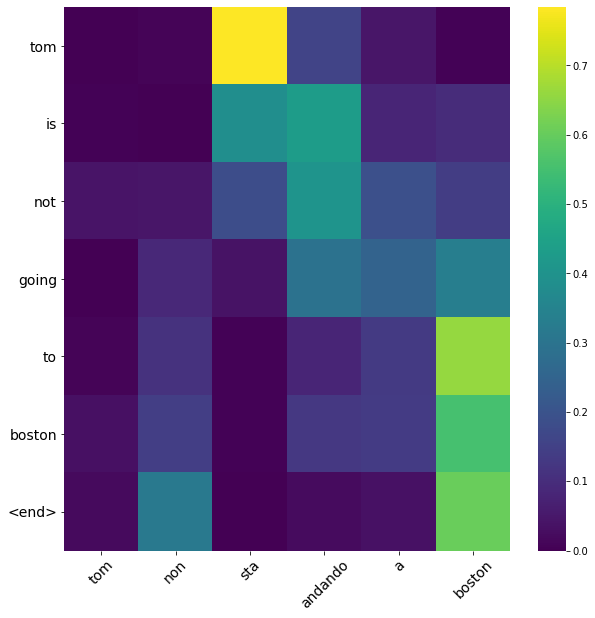

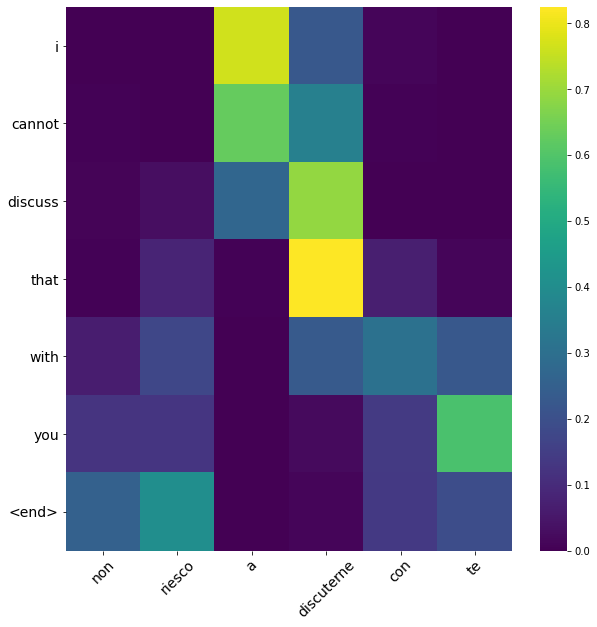

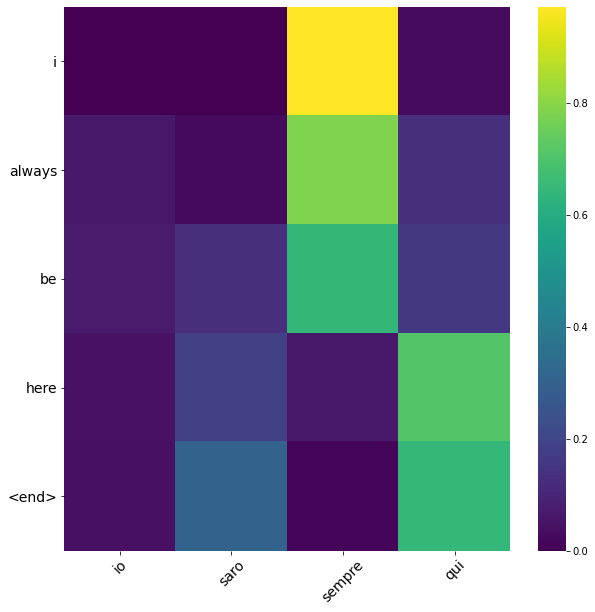

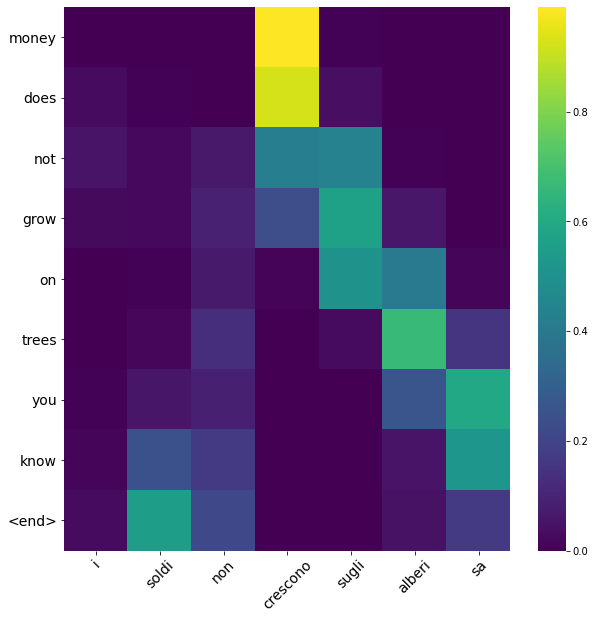

In [ ]:
# Visualize attention weights for random 5 samples
for _ in range(5):
    idx = np.random.randint(0, validation.shape[0])
    _ = predict(validation.iloc[idx]['italian'], plot=True)

In [ ]:
# Prediciton on 10 random samples in test data by model using concat scoring function

for _ in range(10):
    idx = np.random.randint(validation.shape[0])
    print('Input sentence: ', validation['italian'].iloc[idx])
    print('Target sentence: ', validation['english_out'].iloc[idx])
    print('Predicted sentence: ', predict(validation['italian'].iloc[idx]))
    print('-'*80)

Input sentence:  dillo a tom
Target sentence:  tell tom <end>
Predicted sentence:  tell tom <end>
--------------------------------------------------------------------------------
Input sentence:  tom sembra riluttante a farlo
Target sentence:  tom appears unwilling to do that <end>
Predicted sentence:  tom looks reluctant to do that <end>
--------------------------------------------------------------------------------
Input sentence:  sono scoppiate le nostre tubature dellacqua
Target sentence:  our water pipes burst <end>
Predicted sentence:  broke our water pipes <end>
--------------------------------------------------------------------------------
Input sentence:  noi abbiamo un piccolo problema qui
Target sentence:  we have got a little bit of a problem here <end>
Predicted sentence:  we have a little problem here <end>
--------------------------------------------------------------------------------
Input sentence:  dovremmo fare del nostro meglio
Target sentence:  we should do our

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
# %load_ext tensorboard
%tensorboard --logdir logs

### Observation

1. We can see that models with attention weights can translate longer sentences sensibly well compared to that of without attention mechanism
2. Building subclass model is more flexible. We can build our own architecture.
However, it loses some interpretability that keras models give by default